Mallapragada, Pavan Kumar, et al. "Semiboost: Boosting for semi-supervised learning." Pattern Analysis and Machine Intelligence, IEEE Transactions on 31.11 (2009): 2000-2014.

http://www.cse.msu.edu/prip/ResearchProjects/cluster_research/papers/MSU-CSE-07-197.pdf

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.380.9291&rep=rep1&type=pdf

In [106]:
import numpy as np

from sklearn.metrics import pairwise_distances

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris, make_classification, make_gaussian_quantiles
from sklearn.preprocessing import label_binarize

from sklearn.metrics import log_loss
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, ClassifierMixin, clone

from sklearn.utils.extmath import cartesian

from scipy.stats import rv_discrete

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class WeightedAvgClf(BaseEstimator, ClassifierMixin):
    def __init__(self, ests=None, alpha=None):
        if ests is None:
            self.ests = []
        else:
            self.ests = ests
        if alpha is None:
            self.alpha = []
        else:
            self.alpha = alpha
        
    def add_est(self, est, alpha):
        self.ests.append(est)
        self.alpha.append(alpha)

    def fit(self, X, y, **fit_params):
        print 'The estimators should be pre-fit'
        return self

    def predict_proba(self, X, **pred_params):
        preds = np.array([est.predict_proba(X) for est in self.ests])
        preds_w = (np.array(self.alpha)[:, None, None] * preds).sum(axis=0)
        return preds_w / preds_w.sum(axis=1)[:, None]
        
        


In [3]:
X, y = make_gaussian_quantiles(n_features=2, n_classes=3,
                              n_samples=500)
classes = np.unique(y)
K = float(len(classes))

In [4]:
train_split, val_split = iter(StratifiedShuffleSplit(
    y, n_iter=1, test_size=0.9)).next()
X_train, X_val = X[train_split], X[val_split]
y_train, y_val = y[train_split], y[val_split]

In [5]:
S = pairwise_distances(X, metric='cosine', n_jobs=-1)

cart_lu = cartesian([train_split, val_split])
cart_uu = cartesian([val_split, val_split])
S_lu = S[cart_lu[:,0], cart_lu[:,1]].reshape([len(train_split), len(val_split)])
S_uu = S[cart_uu[:,0], cart_uu[:,1]].reshape([len(val_split), len(val_split)])

print X.shape
print S.shape

(500, 2)
(500, 500)


In [8]:
# Y_i = label_binarize(y_train, classes=classes, 
#                      neg_label=-1, pos_label=K-1)/float(K-1)

In [154]:
bc = lambda p, q: np.sqrt(p * q).sum()
D = lambda p, q: -np.log(bc(p, q) + 1e-30)

clf = DecisionTreeClassifier()
# Fit the initial classifier and add to ensemble
H = WeightedAvgClf(
    ests=[clone(clf).fit(X_train, y_train)],
    alpha=[1.],
)
for t in range(20):
    H_pred = H.predict_proba(X_val)
    
    score = log_loss(y_val, H_pred)
    print score
    
#     --------------------------------------------------------------
    C = 1.0    # weight of UU consistency

    loss_lu = np.zeros([len(train_split), len(val_split)])
    for i in range(len(train_split)):
        loss_lu[i, :] = -np.log(H_pred[:, y_train[i]] + 1e-30)
    loss_obs_lu = loss_lu.sum(axis=0)

    loss_uu = pairwise_distances(H_pred, metric=D)
    loss_obs_uu = loss_uu.sum(axis=0)

    loss_obs = loss_obs_lu + C*loss_obs_uu
   
#     --------------------------------------------------------------

    # Create sampling prob distribution from loss_obs (our confidence)
    loss_obs_normed = loss_obs / loss_obs.sum()
    u_sampling_pmf = rv_discrete(values=(range(len(loss_obs_normed)), loss_obs_normed))
    
    # Sample the pseudo-labels based on confidence
    n_xfer = int(len(loss_obs_normed)/10.)  # Sample 10% empircally deteremined by Mallapragada
    xfer_inds = u_sampling_pmf.rvs(size=n_xfer)
    y_xfer = np.argmax(H_pred[xfer_inds, :], axis=1)
    X_xfer = X_val[xfer_inds, :]
    loss_xfer = np.log(loss_obs[xfer_inds].sum())/(K**2)

    # Fit the component classifier
    clf_comp = clone(clf).fit(
        X=np.r_[X_train, X_xfer],
        y=np.r_[y_train, y_xfer],
    )
    
#     --------------------------------------------------------------
    alpha = loss_xfer
    print 'alpha:', alpha
#     --------------------------------------------------------------
    
    H.add_est(clf_comp, alpha)

7.7693015944
alpha: 1.53678185117
7.26145496811
alpha: 1.5322100596
5.62970973935
alpha: 1.52776520189
5.57379984129
alpha: 1.52765663345
5.42620342359
alpha: 1.51915915375
5.43275841935
alpha: 1.52670539329
5.43880922131
alpha: 1.51982931366
5.44341120051
alpha: 1.5243199236
5.37878771277
alpha: 1.51657890015
5.31483260684
alpha: 1.52340412664
5.24457886011
alpha: 1.52296889809
4.67472648185
alpha: 1.5213259274
4.67769862869
alpha: 1.51440472746
4.68199644112
alpha: 1.51946849766
4.68129911377
alpha: 1.51539767623
4.68395039338
alpha: 1.51904053196
4.68943890919
alpha: 1.51670743211
4.6946262053
alpha: 1.52253929049
4.69730777194
alpha: 1.51915824905
4.70008057908
alpha: 1.51696997278


In [149]:
H.alpha

[1.0,
 1.0148851746165706,
 1.0141631604172081,
 1.0132210888257738,
 1.0141819076167746,
 1.0095793093807499,
 1.0066463928034333,
 1.0046899682593589,
 1.0067869713103776,
 1.0012022605757387,
 1.0078753594221572,
 1.0078028724183798,
 1.005134670740681,
 1.0050636024820701,
 1.0073769485919306,
 1.0058669589929703,
 1.0052745534681764,
 1.0089654828866683,
 1.0082454429816858,
 1.0088863766212093,
 1.0072986277549139,
 1.0076846997466002,
 1.0075733408941441,
 1.0083547264838577,
 1.0055562704514527,
 1.0055650478203857,
 0.9998960446022459,
 1.007911120291016,
 1.0010177049147371,
 1.0023352462807822,
 1.0069529491186178,
 1.0046038715422121,
 1.0040872556036133,
 1.0020728574334063,
 1.0009163574258297,
 1.0042754058424259,
 1.0024476367930597,
 1.0045568007151582,
 1.0007886899493681,
 1.0031851007160231,
 0.99931896142725085,
 0.99576969526787218,
 0.99506899824467598,
 0.99479235362700125,
 1.0020642150574173,
 0.99596863320126838,
 0.99528065408471278,
 0.9983422918412802,
 0.

In [99]:
print loss_lu.shape
print loss_uu.shape
print loss_obs_lu.shape
print loss_obs_uu.shape
print loss_obs.shape

(51, 449)
(449, 449)
(449,)
(449,)
(449,)


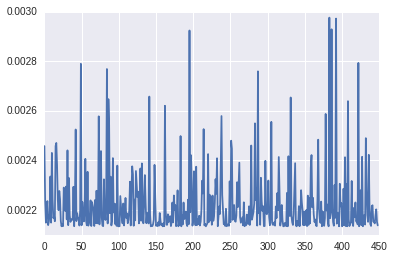

In [109]:
plt.plot(loss_obs_normed)

In [143]:
H_pred[:, y_train[i]]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1